# ML for customer churn prediction in telecom

#### In this notebook, the following ML models are developed for churn prediction:
    1. Logistic regression
    2. Decision Tree
    3. Random Forest
    4. Ridge CV classifier
    5. XGBoost
    
    

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# Data preparation

In [3]:
# read the data that we preprocessed in the Preprocessing notebook
preprocessed_data = pd.read_csv('preprocessed_data_telecom.csv')
preprocessed_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,Not senior,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,Not senior,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,Not senior,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,Not senior,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,Not senior,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Check for null values
preprocessed_data.isnull().sum() # Therefore there is no missing values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
# Check the type of data in each column
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [6]:
# Drop customerID column since we do not need it for ML
try:
    preprocessed_data = preprocessed_data.drop(columns=['customerID'])
except Exception:
    pass

# Machine learning

The goal of this machine learning study is to develop models to predict churn based on customer demographic, service plan, media usage, and tenure time information. the ML problem is defined as a binary classification problem.

### Encode churn column

In [7]:
# Convert churn from 'No' and 'Yes' to 0 and 1
preprocessed_data['Churn'] = preprocessed_data['Churn'].replace({'Yes':1, 'No':0})

In [8]:
X = preprocessed_data.drop(columns=['Churn'])
y = preprocessed_data['Churn']

### Perform train test split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

### Define the ColumnTransformer

In [10]:
# Categorical columns with more than 2 categories
cat_w_3 = ['MultipleLines', 'InternetService','OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']
# Categorical columns with 2 categories. We treat these as binary columns
cat_w_2 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService','PaperlessBilling']

transformer = ColumnTransformer([
    ('one_hot_transformer', OneHotEncoder(sparse=False), cat_w_3),
    ('binary_transformer', OneHotEncoder(sparse=False, drop='first'), cat_w_2)], 
    remainder='passthrough')

In [11]:
transformer.fit_transform(X_train).shape

(5625, 40)

### Define a function to evaluate the model on the test set

In [12]:
def model_evaluation(model, X, y_true):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred), 4)
    try:
        probs = model.predict_proba(X).T[1]
        precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs)
        scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    except Exception:
        pass
    return scores

### Define a function for model evaluation with cross validation

In [13]:
def model_cv_scores(model, X_train, y_train):
    shuffle = KFold(n_splits=5, random_state=0, shuffle=True)
    scores = cross_validate(model, X_train,y_train, cv=shuffle, scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc'))
    cv_scores = {}
    cv_scores['Mean_accuracy'] = round(scores['test_accuracy'].mean(),4)
    cv_scores['Mean_precision'] = round(scores['test_precision'].mean(),4)
    cv_scores['Mean_recall'] = round(scores['test_recall'].mean(),4)
    cv_scores['Mean_f1'] = round(scores['test_f1'].mean(),4)
    cv_scores['Mean_auc'] = round(scores['test_roc_auc'].mean(),4)
    return cv_scores

# ML Models

## 1- Logistic regression model

In [14]:
lr_pipe = Pipeline([('transformer',transformer),
                 ('scaler', StandardScaler()),
                 ('estimator',LogisticRegression(solver='liblinear',))])
#lr_pipe.fit(X_train,y_train);

#### Tune hyperparameters

In [15]:
#lr_pipe.get_params()

In [16]:
lr_grid_params = {'estimator__C':[100, 10, 1.0, 0.1, 0.01]}
lr_pipe_tuned = GridSearchCV(lr_pipe, lr_grid_params, cv=5, n_jobs=5, verbose=1)
lr_pipe_tuned.fit(X_train,y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [17]:
lr_pipe_tuned.best_estimator_['estimator']

LogisticRegression(C=10, solver='liblinear')

In [18]:
lr_pipe_tuned.best_score_

0.8032000000000001

#### cross validation scores

In [19]:
model_cv_scores(lr_pipe_tuned.best_estimator_, X_train, y_train)

{'Mean_accuracy': 0.8032,
 'Mean_precision': 0.6522,
 'Mean_recall': 0.5573,
 'Mean_f1': 0.6008,
 'Mean_auc': 0.8461}

#### Test set evaluation scores

In [20]:
lr_test_scores = model_evaluation(lr_pipe_tuned.best_estimator_, X_train, y_train)
lr_test_scores

{'accuracy': 0.806,
 'precision': 0.6601,
 'recall': 0.5572,
 'area under precision-recall curve': 0.6644}

## 2- Decision tree model

In [21]:
dt_pipe = Pipeline([('transformer',transformer),
                  ('scaler', StandardScaler()),
                  ('estimator',DecisionTreeClassifier())])
#dt_pipe.fit(X_train,y_train);

#### Tune hyperparameters

In [22]:
#dt_pipe.get_params()

In [23]:
dt_grid_params = {'estimator__max_depth':range(2,22,2)}
dt_pipe_tuned = GridSearchCV(dt_pipe, dt_grid_params, cv=5, n_jobs=5, verbose=1)
dt_pipe_tuned.fit(X_train,y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [24]:
dt_pipe_tuned.best_estimator_['estimator']

DecisionTreeClassifier(max_depth=4)

In [25]:
dt_pipe_tuned.best_score_

0.7882666666666667

#### cross validation scores

In [26]:
model_cv_scores(dt_pipe_tuned.best_estimator_, X_train, y_train)

{'Mean_accuracy': 0.7888,
 'Mean_precision': 0.6469,
 'Mean_recall': 0.4789,
 'Mean_f1': 0.5435,
 'Mean_auc': 0.8239}

#### Test set evaluation scores

In [27]:
dt_test_scores = model_evaluation(dt_pipe_tuned.best_estimator_, X_test, y_test)
dt_test_scores

{'accuracy': 0.8003,
 'precision': 0.6545,
 'recall': 0.5267,
 'area under precision-recall curve': 0.6313}

## 3- Random forest model

In [28]:
rf_pipe = Pipeline([('transformer',transformer),
                  ('scaler', StandardScaler()),
                  ('estimator',RandomForestClassifier())])
#rf_pipe.fit(X_train,y_train);

#### Tune hyperparameters

In [29]:
#rf_pipe.get_params()

In [30]:
rf_grid_params = {'estimator__max_depth':range(2,12,2), 'estimator__n_estimators':[10,50,100]}
rf_pipe_tuned = GridSearchCV(rf_pipe, rf_grid_params, cv=5, n_jobs=5, verbose=1)
rf_pipe_tuned.fit(X_train,y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [31]:
rf_pipe_tuned.best_estimator_.named_steps['estimator']

RandomForestClassifier(max_depth=6, n_estimators=50)

In [32]:
rf_pipe_tuned.best_score_

0.8016

#### cross validation scores

In [33]:
model_cv_scores(rf_pipe_tuned.best_estimator_, X_train, y_train)

{'Mean_accuracy': 0.8028,
 'Mean_precision': 0.676,
 'Mean_recall': 0.4956,
 'Mean_f1': 0.5717,
 'Mean_auc': 0.8471}

#### Test set evaluation scores

In [34]:
rf_test_scores = model_evaluation(rf_pipe_tuned.best_estimator_, X_test, y_test)
rf_test_scores

{'accuracy': 0.8017,
 'precision': 0.6599,
 'recall': 0.5241,
 'area under precision-recall curve': 0.6599}

## 4- Ridge classifier cv model

In [35]:
ridge_cv_pipe = Pipeline([('transformer',transformer),
                  ('scaler', StandardScaler()),
                  ('estomator',RidgeClassifierCV(alphas=[0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 2, 4, 6, 8, 10]))])
ridge_cv_pipe.fit(X,y);

#### cross validation scores

In [36]:
model_cv_scores(rf_pipe, X_train, y_train)

{'Mean_accuracy': 0.7883,
 'Mean_precision': 0.6353,
 'Mean_recall': 0.4803,
 'Mean_f1': 0.5457,
 'Mean_auc': 0.8235}

#### Test set evaluation scores

In [37]:
ridge_cv_test_scores = model_evaluation(ridge_cv_pipe, X_test, y_test)
ridge_cv_test_scores

{'accuracy': 0.806, 'precision': 0.6656, 'recall': 0.5428}

## 5- XGBoost classifier model

In [38]:
xgb_pipe = Pipeline([('transformer',transformer),
                  ('scaler', StandardScaler()),
                  ('estimator',XGBClassifier(eval_metric='logloss',use_label_encoder=False))])
#xgb_pipe.fit(X,y);

#### Tune hyperparameters

In [39]:
#xgb_pipe.get_params()

In [40]:
xgb_grid_params = {'estimator__max_depth':range(2,12,2), 'estimator__n_estimators':[10,50,100, 150]}
xgb_pipe_tuned = GridSearchCV(xgb_pipe, xgb_grid_params, cv=5, n_jobs=5, verbose=1)
xgb_pipe_tuned.fit(X_train,y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [41]:
xgb_pipe_tuned.best_estimator_.named_steps['estimator']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [42]:
xgb_pipe_tuned.best_score_

0.8005333333333334

#### cross validation scores

In [43]:
model_cv_scores(xgb_pipe_tuned.best_estimator_, X_train, y_train)

{'Mean_accuracy': 0.8046,
 'Mean_precision': 0.6659,
 'Mean_recall': 0.5331,
 'Mean_f1': 0.5915,
 'Mean_auc': 0.8484}

#### Test set evaluation scores

In [44]:
xgb_test_scores = model_evaluation(xgb_pipe_tuned.best_estimator_, X_test, y_test)
xgb_test_scores

{'accuracy': 0.7989,
 'precision': 0.6426,
 'recall': 0.5481,
 'area under precision-recall curve': 0.6565}

## Compare accuracy of different models

In [45]:
model_names = ['LogisticRegression','DecisionTree','RandomForest','RidgeClassifierCV','XGBoost']
model_accuracies = [lr_test_scores['accuracy'],dt_test_scores['accuracy'],rf_test_scores['accuracy'],ridge_cv_test_scores['accuracy'],xgb_test_scores['accuracy']]
model_precision = [lr_test_scores['precision'],dt_test_scores['precision'],rf_test_scores['precision'],ridge_cv_test_scores['precision'],xgb_test_scores['precision']]
model_recall = [lr_test_scores['recall'],dt_test_scores['recall'],rf_test_scores['recall'],ridge_cv_test_scores['recall'],xgb_test_scores['recall']]

In [46]:
models_df = pd.DataFrame({'model_names':model_names, 'accuracies':model_accuracies, 'precicions':model_precision, 'recalls':model_recall})

In [47]:
models_df

,model_names,accuracies,precicions,recalls
0,LogisticRegression,0.8060,0.6601,0.5572
1,DecisionTree,0.8003,0.6545,0.5267
2,RandomForest,0.8017,0.6599,0.5241
3,RidgeClassifierCV,0.8060,0.6656,0.5428
4,XGBoost,0.7989,0.6426,0.5481


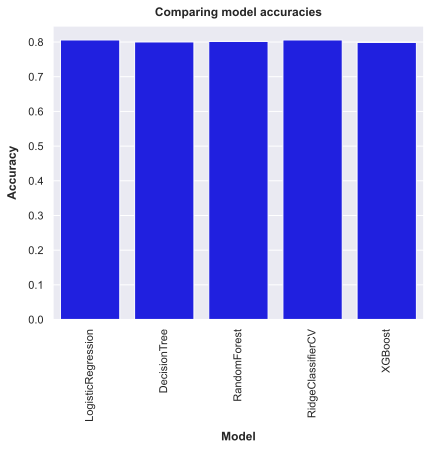

In [48]:
fig,ax = plt.subplots(figsize=(6,6))
sns.barplot(x="model_names", y="accuracies", color='blue', data=models_df)
plt.xticks(rotation=90)
plt.tight_layout()
ax.set_xlabel('Model', labelpad=10, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=10, fontweight='bold')
ax.set_title('Comparing model accuracies',pad=10, fontweight='bold');
imagename = '2_1_1_Comparing_model_accuraries'
plt.savefig(f'./images/{imagename}.svg')

## Compare recall score from different models

Note: from a buissiness point of view, **models with higher recall are more desirable** since higher recall is assiciated with less False Negatives which in this case is related to lower number of customers that churned but predicted as not-churned. 

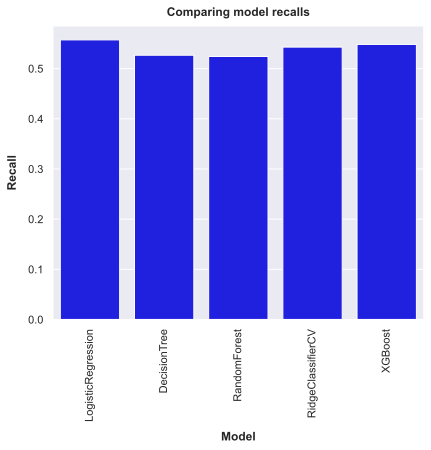

In [49]:
fig,ax = plt.subplots(figsize=(6,6))
sns.barplot(x="model_names", y="recalls", color='blue', data=models_df)
plt.xticks(rotation=90)
plt.tight_layout()
ax.set_xlabel('Model', labelpad=10, fontweight='bold')
ax.set_ylabel('Recall', labelpad=10, fontweight='bold')
ax.set_title('Comparing model recalls',pad=10, fontweight='bold');
imagename = '2_1_2_Comparing_model_recalls'
plt.savefig(f'./images/{imagename}.svg')

### Result of model comparison

According to the results, all models very similar results. For instance the accuracy of all models are about **0.8** on the test set

Based on the results, **logistic regression model** has the highest **recall score** therefore from a bussiness point of view this model is more desirable

## Feature importance

#### Logistic regression feature importance

In [50]:
# get importance
lr_importance = lr_pipe_tuned.best_estimator_['estimator'].coef_[0]

#### Random forest feature importance

In [51]:
# get importance
rf_importance = rf_pipe_tuned.best_estimator_['estimator'].feature_importances_

### Plot feature importances

In [52]:
feature_names = lr_pipe['transformer'].get_feature_names()

In [53]:
new_feature_names = ['MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check',
 'gender_Male',
 'SeniorCitizen_Senior',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'PaperlessBilling_Yes',
 'tenure',
 'MonthlyCharges',
 'TotalCharges']

In [54]:
df = pd.DataFrame({'feature_names': new_feature_names, 'LogisticRegression':abs(lr_importance)/max(abs(lr_importance)), 'RandomForest':abs(rf_importance)/max(abs(rf_importance))})
df2 = pd.melt(df, id_vars=['feature_names'], value_vars=['LogisticRegression','RandomForest'])

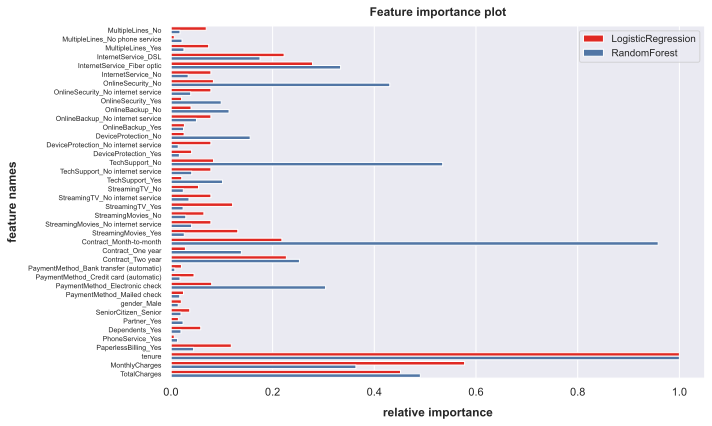

In [55]:
fig,ax = plt.subplots(figsize=(10,6))
colors = ["#FF0B04", "#4374B3"]
sns.set_palette(sns.color_palette(colors))
sns.barplot(x="value", y="feature_names", hue="variable", data=df2)
ax.set_yticklabels(new_feature_names, fontdict={'fontsize':7})
#ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('relative importance', labelpad=10, fontweight='bold')
ax.set_ylabel('feature names', labelpad=10, fontweight='bold')
ax.set_title('Feature importance plot',pad=10, fontweight='bold')
plt.tight_layout()
plt.legend(prop={'size': 10})
imagename = '2_2_Feature_importance_plot'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

### Results of feature importance analysis

Based on the results, it seems that the most important variables are 'Tenure', 'MonthlyCharges', 'TotalCharges', and 'ContractType'

# Plot learning curves to examine if increasing the size of training data improves the models

In [56]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes.set_title(title, pad=10, fontweight='bold')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples", labelpad=10, fontweight='bold')
    axes.set_ylabel("Score", labelpad=10, fontweight='bold')

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")


    return plt

## Learning curve for the logistic regression model

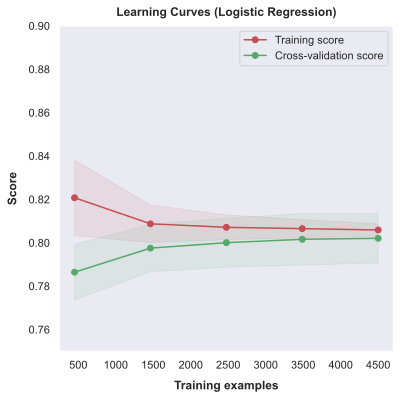

In [57]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = lr_pipe_tuned.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train, axes=axes, ylim=(0.75, 0.9),
                    cv=cv, n_jobs=4)
imagename = '2_3_LearningCurve_logistic_regression_model'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

## Learning curve for the decision tree model

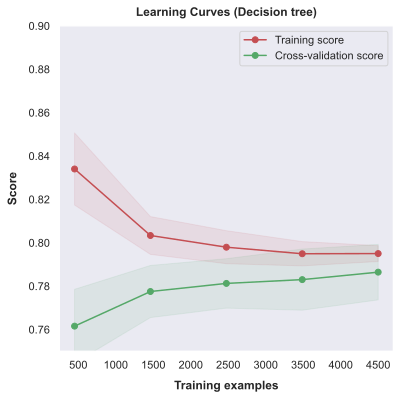

In [58]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
title = "Learning Curves (Decision tree)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = dt_pipe_tuned.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train, axes=axes, ylim=(0.75, 0.9),
                    cv=cv, n_jobs=4)
imagename = '2_4_LearningCurve_decision_tree_model'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

## Learning curve for random forest model

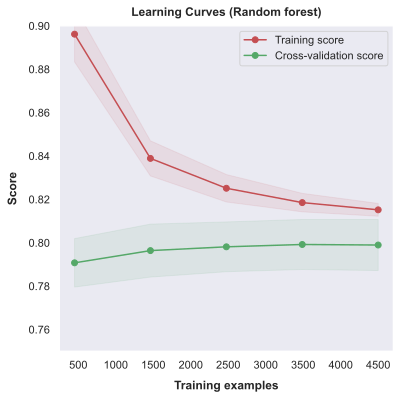

In [59]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
title = "Learning Curves (Random forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = rf_pipe_tuned.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train, axes=axes, ylim=(0.75, 0.9),
                    cv=cv, n_jobs=4)
imagename = '2_5_LearningCurve_random_forest_model'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

## Learning curve for the Ridge classifier cv model

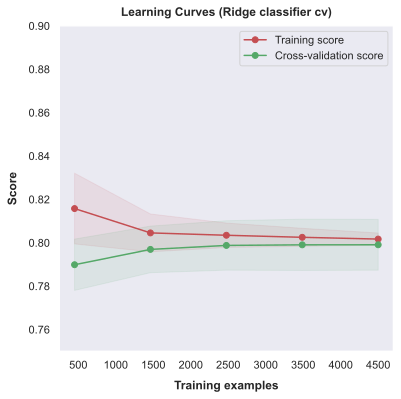

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
title = "Learning Curves (Ridge classifier cv)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = ridge_cv_pipe
plot_learning_curve(estimator, title, X_train, y_train, axes=axes, ylim=(0.75, 0.9),
                    cv=cv, n_jobs=4)
imagename = '2_6_LearningCurve_ridge_classifier_cv_model'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

## Learning curve for the XGBoost classifier model

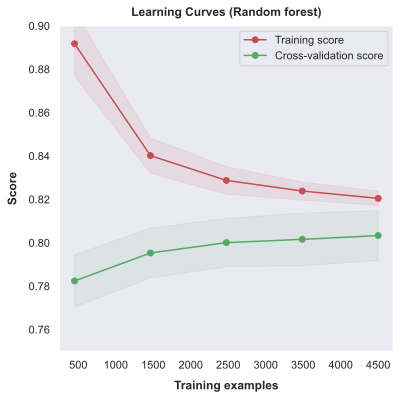

In [61]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
title = "Learning Curves (Random forest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = xgb_pipe_tuned.best_estimator_
plot_learning_curve(estimator, title, X_train, y_train, axes=axes, ylim=(0.75, 0.9),
                    cv=cv, n_jobs=4)
imagename = '2_7_LearningCurve_XGBoost_classifier_model'
plt.savefig(f'./images/{imagename}.svg')
plt.show()

### Based on the learning curves it seems that more data will not significantly improve these models.

# Use ML models to predict churn for customers

In [62]:
# chose a customer from the test set
n = 5
test_customer = X_test.iloc[[n]]
customer_churn = y_test.iloc[n]
lr_prediction = lr_pipe_tuned.best_estimator_.predict(test_customer)
dt_prediction = dt_pipe_tuned.best_estimator_.predict(test_customer)
rf_prediction = rf_pipe_tuned.best_estimator_.predict(test_customer)
RidgeCv_prediction = ridge_cv_pipe.predict(test_customer)
xgb_prediction = xgb_pipe_tuned.best_estimator_.predict(test_customer)

In [63]:
print(f'Observed churn for this customer is: {customer_churn}')
print(f'Logistic regression model prediction: {lr_prediction}')
print(f'Decision tree model prediction: {dt_prediction}')
print(f'Random Forest model prediction: {rf_prediction}')
print(f'Ridge CV classifier model prediction: {RidgeCv_prediction}')
print(f'XGBoost model prediction: {xgb_prediction}')

Observed churn for this customer is: 0
Logistic regression model prediction: [0]
Decision tree model prediction: [0]
Random Forest model prediction: [0]
Ridge CV classifier model prediction: [0]
XGBoost model prediction: [0]
